In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=7a09fe49149865f3f00654da7e27bd41a0828ffaea7015b4775296f9318b18c2
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
!pip install matplotlib seaborn

K-means Silhouette Score: 0.7482611209321568


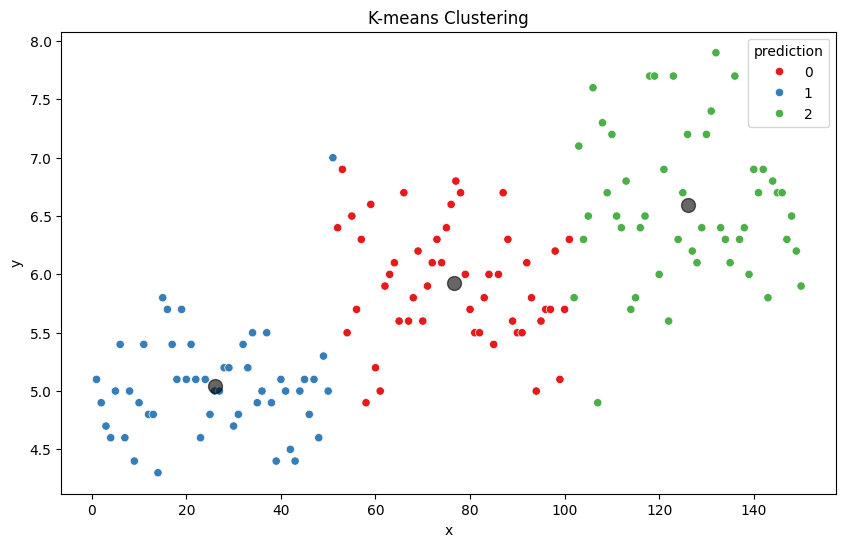

Bisecting K-means Silhouette Score: 0.6682923027480289


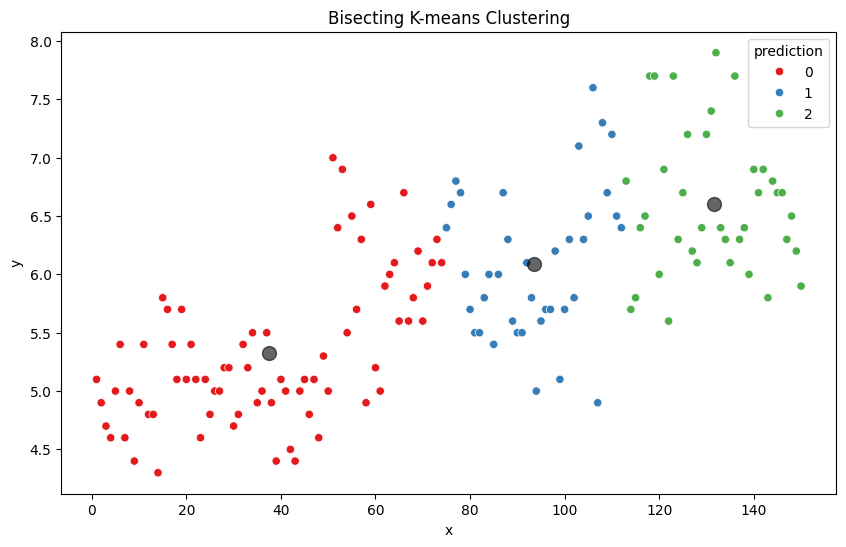

Decision Tree Accuracy: 1.0


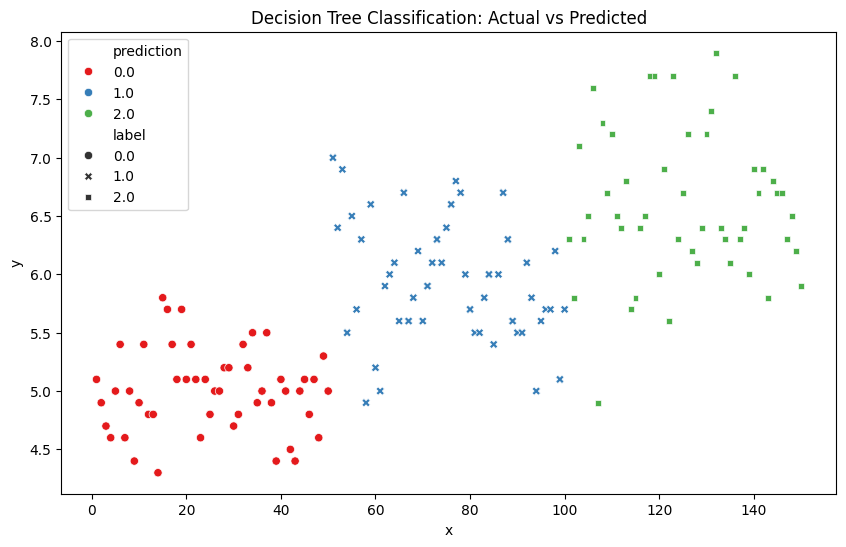

In [7]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder.appName("IrisAnalysis").getOrCreate()

# Load data
data = spark.read.csv("Iris.csv", header=True, inferSchema=True)

# Prepare features
feature_columns = data.columns[:-1]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_with_features = assembler.transform(data) # Create a new DataFrame with features

# K-means Clustering
kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(data_with_features)
predictions = model.transform(data_with_features)

# Evaluate K-means
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"K-means Silhouette Score: {silhouette}")

# Visualize K-means clustering
kmeans_centers = model.clusterCenters()
kmeans_predictions = predictions.select("features", "prediction").toPandas()
kmeans_predictions["x"] = kmeans_predictions["features"].apply(lambda x: x[0])
kmeans_predictions["y"] = kmeans_predictions["features"].apply(lambda x: x[1])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=kmeans_predictions, x="x", y="y", hue="prediction", palette="Set1")
plt.scatter([center[0] for center in kmeans_centers], [center[1] for center in kmeans_centers], c='black', s=100, alpha=0.6)
plt.title("K-means Clustering")
plt.show()

# Bisecting K-means Clustering
bkm = BisectingKMeans(k=3, seed=1)
model_bkm = bkm.fit(data_with_features)
predictions_bkm = model_bkm.transform(data_with_features)

# Evaluate Bisecting K-means
evaluator_bkm = ClusteringEvaluator()
silhouette_bkm = evaluator_bkm.evaluate(predictions_bkm)
print(f"Bisecting K-means Silhouette Score: {silhouette_bkm}")

# Visualize Bisecting K-means clustering
bkm_centers = model_bkm.clusterCenters()
bkm_predictions = predictions_bkm.select("features", "prediction").toPandas()
bkm_predictions["x"] = bkm_predictions["features"].apply(lambda x: x[0])
bkm_predictions["y"] = bkm_predictions["features"].apply(lambda x: x[1])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=bkm_predictions, x="x", y="y", hue="prediction", palette="Set1")
plt.scatter([center[0] for center in bkm_centers], [center[1] for center in bkm_centers], c='black', s=100, alpha=0.6)
plt.title("Bisecting K-means Clustering")
plt.show()

# Decision Tree Classification
indexer = StringIndexer(inputCol="Species", outputCol="label") # Use original 'Species' column
data_with_label = indexer.fit(data_with_features).transform(data_with_features) # Create new DataFrame with label column by applying StringIndexer to data_with_features

dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
model_dt = dt.fit(data_with_label) # Use DataFrame with features and label

# Evaluate Decision Tree
evaluator_dt = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_dt.evaluate(model_dt.transform(data_with_label))
print(f"Decision Tree Accuracy: {accuracy}")

# Visualize Decision Tree results
dt_predictions = model_dt.transform(data_with_label).select("features", "label", "prediction").toPandas() # Continue with visualization
dt_predictions["x"] = dt_predictions["features"].apply(lambda x: x[0])
dt_predictions["y"] = dt_predictions["features"].apply(lambda x: x[1])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=dt_predictions, x="x", y="y", hue="prediction", palette="Set1", style="label")
plt.title("Decision Tree Classification: Actual vs Predicted")
plt.show()
